# Marketing Analytics Predictor
This is a ML model trained to predict the total revenue of a marketing campaign based on user-provided parameters. It utilizes a best trained model for the core predictions.

## Data Exploration and Preprocessing

After importing all neccessary libraries and reading the file using pandas, We will run EDA as part of our data exploration and preprocessing. It is important to know the structure and summary of the dataset before working on it. Also we have to check if there are any missing values and if any column has outliers.

### Information about structure of our dataset

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

In [243]:
df = pd.read_csv("campaigns_unified_data.csv")

In [244]:
print(df.shape)
print(df.dtypes)
df.head()

(600, 15)
Campaign_ID               object
Status                    object
Channel                   object
Objective                 object
Audience                  object
Geo                       object
Creative_Type             object
Budget                     int64
Start_Date                object
End_Date                  object
Spend_Till_Date          float64
Impressions_Till_Date      int64
Clicks_Till_Date           int64
Conversions_Till_Date      int64
Revenue_Till_Date        float64
dtype: object


,Campaign_ID,Status,Channel,Objective,Audience,Geo,Creative_Type,Budget,Start_Date,End_Date,Spend_Till_Date,Impressions_Till_Date,Clicks_Till_Date,Conversions_Till_Date,Revenue_Till_Date
0,A0039,Active,Facebook,Awareness,Professionals,SEA,Video,13085,03-09-2025,03-10-2025,1904.47,89351,4111,465,39014.89
1,A0004,Active,Instagram,Awareness,Adults,UK,Video,16302,03-09-2025,02-10-2025,2517.96,73341,2272,211,16694.93
2,A0044,Active,Facebook,Sales,Youth,US,Image,8988,03-09-2025,02-10-2025,1409.12,41938,1671,192,25905.09
3,A0107,Active,LinkedIn,Leads,Youth,US,Image,10171,03-09-2025,02-10-2025,1846.96,92332,4604,485,61545.89
4,A0005,Active,Google,Sales,Youth,India,Video,8475,02-09-2025,02-10-2025,1700.02,41114,891,77,7361.74


#### Converting date columns from object to pandas datetime.

In [245]:
df['Start_Date'] = pd.to_datetime(df['Start_Date'], dayfirst=True)
df['End_Date'] = pd.to_datetime(df['End_Date'], dayfirst=True)

### Describing data with Summary Statistics

In [246]:
numerical_cols = []
for column in df.columns:
    if df[column].dtype in ["int64", "float64"]:
        numerical_cols.append(column)
        
numerical_cols

['Budget',
 'Spend_Till_Date',
 'Impressions_Till_Date',
 'Clicks_Till_Date',
 'Conversions_Till_Date',
 'Revenue_Till_Date']

In [247]:
df.describe()

,Budget,Start_Date,End_Date,Spend_Till_Date,Impressions_Till_Date,Clicks_Till_Date,Conversions_Till_Date,Revenue_Till_Date
count,600.000000,600,600,600.000000,6.000000e+02,600.000000,600.000000,6.000000e+02
mean,14800.616667,2025-07-28 20:12:00,2025-08-17 23:19:12,14351.031917,5.412619e+05,18734.523333,2047.153333,2.327999e+05
min,5253.000000,2025-06-10 00:00:00,2025-06-21 00:00:00,1115.110000,2.588300e+04,744.000000,41.000000,2.537150e+03
25%,11074.750000,2025-07-05 00:00:00,2025-07-26 00:00:00,9243.932500,3.013232e+05,7826.500000,780.000000,7.159215e+04
50%,14752.500000,2025-08-04 00:00:00,2025-08-20 12:00:00,13736.920000,4.881945e+05,15994.500000,1511.000000,1.573118e+05
75%,18436.500000,2025-08-22 00:00:00,2025-09-12 00:00:00,19073.172500,7.363140e+05,26130.750000,2755.000000,3.317696e+05
max,24969.000000,2025-09-03 00:00:00,2025-10-03 00:00:00,48297.170000,2.263926e+06,79854.000000,11099.000000,1.434598e+06
std,4812.356507,NaN,NaN,7427.174519,3.142077e+05,13951.948600,1753.710842,2.228505e+05


In [248]:
(df[numerical_cols] == 0).sum().sort_values(ascending= False)

Budget                   0
Spend_Till_Date          0
Impressions_Till_Date    0
Clicks_Till_Date         0
Conversions_Till_Date    0
Revenue_Till_Date        0
dtype: int64

### Outliers Checking

Now we will perform outliers detection for above numerical data columns. We will choose only relevant columns which are subject to distribution.

In [249]:
remove_num_cols = ["Campaign_Duration", "Duration_Till_Date"]
numerical_cols = [col for col in numerical_cols if col not in remove_num_cols]

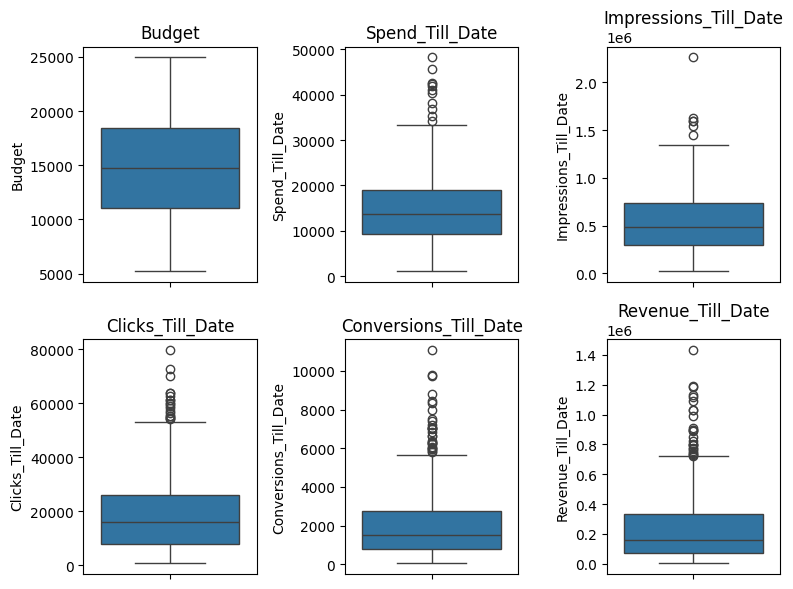

In [255]:
plt.figure(figsize = (8,6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2,3, i+1)
    sns.boxplot(df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Each plot displays the distribution, median, and outliers. Metrics include Budget, Spend, Impressions, Clicks, Conversions, and Revenue. Most show a right-skewed distribution with several high outliers.

### Missing Values Analysis

In [256]:
missing = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percentage})
print(missing_df[missing_df['Missing Count'] > 0])

Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


Our dataset does not contain any missing value.

## Feature Engineering

Feature Engineering is a crucial process of transforming existing data into usable features in machine learning. We create new features, select and drop existing features and then perform encoding and scaling.

#### Part 1 : Feature Extraction, Creating New Feature
#####
 * Campaign Duration is calculated using starting and ending date of campaign.
 * Campaign KPIs calculated using existing column like clicks, impressions, conversions, etc.

In [257]:
df_feat = df.drop(["Campaign_ID"], axis = 1)

In [258]:
df_feat["Campaign_Duration"] = (df_feat["End_Date"] - df_feat["Start_Date"]).dt.days
df_feat.head()

,Status,Channel,Objective,Audience,Geo,Creative_Type,Budget,Start_Date,End_Date,Spend_Till_Date,Impressions_Till_Date,Clicks_Till_Date,Conversions_Till_Date,Revenue_Till_Date,Campaign_Duration
0,Active,Facebook,Awareness,Professionals,SEA,Video,13085,2025-09-03,2025-10-03,1904.47,89351,4111,465,39014.89,30
1,Active,Instagram,Awareness,Adults,UK,Video,16302,2025-09-03,2025-10-02,2517.96,73341,2272,211,16694.93,29
2,Active,Facebook,Sales,Youth,US,Image,8988,2025-09-03,2025-10-02,1409.12,41938,1671,192,25905.09,29
3,Active,LinkedIn,Leads,Youth,US,Image,10171,2025-09-03,2025-10-02,1846.96,92332,4604,485,61545.89,29
4,Active,Google,Sales,Youth,India,Video,8475,2025-09-02,2025-10-02,1700.02,41114,891,77,7361.74,30


In [259]:
df_feat = df_feat.drop(["Start_Date", "End_Date"], axis = 1)

In [260]:
df_feat["CTR"] = np.where(df_feat["Impressions_Till_Date"] > 0,
                     df_feat["Clicks_Till_Date"] / df_feat["Impressions_Till_Date"],
                     0)

df_feat["CPC"] = np.where(df_feat["Clicks_Till_Date"] > 0,
                     df_feat["Spend_Till_Date"] / df_feat["Clicks_Till_Date"],
                     0)

df_feat["CPA"] = np.where(df_feat["Conversions_Till_Date"] > 0,
                     df_feat["Spend_Till_Date"] / df_feat["Conversions_Till_Date"],
                     0)

df_feat.head()

,Status,Channel,Objective,Audience,Geo,Creative_Type,Budget,Spend_Till_Date,Impressions_Till_Date,Clicks_Till_Date,Conversions_Till_Date,Revenue_Till_Date,Campaign_Duration,CTR,CPC,CPA
0,Active,Facebook,Awareness,Professionals,SEA,Video,13085,1904.47,89351,4111,465,39014.89,30,0.046010,0.463262,4.095634
1,Active,Instagram,Awareness,Adults,UK,Video,16302,2517.96,73341,2272,211,16694.93,29,0.030979,1.108257,11.933460
2,Active,Facebook,Sales,Youth,US,Image,8988,1409.12,41938,1671,192,25905.09,29,0.039845,0.843279,7.339167
3,Active,LinkedIn,Leads,Youth,US,Image,10171,1846.96,92332,4604,485,61545.89,29,0.049864,0.401164,3.808165
4,Active,Google,Sales,Youth,India,Video,8475,1700.02,41114,891,77,7361.74,30,0.021671,1.907991,22.078182


## Feature Encoding
 * To start working with encoding we should know which column falls under which category (nominal, ordinal). By deciding the same we can choose an encoding method.
 * Label encoding imposes an arbitrary order on categorical data, which can be misleading. So we will use One-Hot encoding method for nominal categorical data and Binary encoding for columns having two categories.
 * One-hot encoding can lead to high dimensionality with many unique categories and can also cause multicollinearity. In order to overcome the problem of multicollinearity, one of the dummy variables has to be dropped.

In [261]:
nominal_cols = ["Status", "Channel", "Objective", "Audience", "Geo", "Creative_Type"]
df_feat[nominal_cols].nunique()

Status           2
Channel          5
Objective        4
Audience         4
Geo              4
Creative_Type    3
dtype: int64

In [262]:
one_hot_cols = ["Channel", "Objective", "Audience", "Geo", "Creative_Type"]
binary_cols = ["Status"]

In [263]:
df_encoded = df_feat.copy()

df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols, drop_first=True, dtype='int')

for col in binary_cols:
    df_encoded[col] = df_encoded[col].map({"Completed": 1, "Active": 0})

In [264]:
df_encoded.head()

,Status,Budget,Spend_Till_Date,Impressions_Till_Date,Clicks_Till_Date,Conversions_Till_Date,Revenue_Till_Date,Campaign_Duration,CTR,CPC,...,Objective_Sales,Objective_Traffic,Audience_Professionals,Audience_Seniors,Audience_Youth,Geo_SEA,Geo_UK,Geo_US,Creative_Type_Image,Creative_Type_Video
0,0,13085,1904.47,89351,4111,465,39014.89,30,0.046010,0.463262,...,0,0,1,0,0,1,0,0,0,1
1,0,16302,2517.96,73341,2272,211,16694.93,29,0.030979,1.108257,...,0,0,0,0,0,0,1,0,0,1
2,0,8988,1409.12,41938,1671,192,25905.09,29,0.039845,0.843279,...,1,0,0,0,1,0,0,1,1,0
3,0,10171,1846.96,92332,4604,485,61545.89,29,0.049864,0.401164,...,0,0,0,0,1,0,0,1,1,0
4,0,8475,1700.02,41114,891,77,7361.74,30,0.021671,1.907991,...,1,0,0,0,1,0,0,0,0,1


In [265]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Status                  600 non-null    int64  
 1   Budget                  600 non-null    int64  
 2   Spend_Till_Date         600 non-null    float64
 3   Impressions_Till_Date   600 non-null    int64  
 4   Clicks_Till_Date        600 non-null    int64  
 5   Conversions_Till_Date   600 non-null    int64  
 6   Revenue_Till_Date       600 non-null    float64
 7   Campaign_Duration       600 non-null    int64  
 8   CTR                     600 non-null    float64
 9   CPC                     600 non-null    float64
 10  CPA                     600 non-null    float64
 11  Channel_Google          600 non-null    int64  
 12  Channel_Instagram       600 non-null    int64  
 13  Channel_LinkedIn        600 non-null    int64  
 14  Channel_YouTube         600 non-null    in

#### Part 3 : Feature Transformation

 * As we discussed in Outliers Detection part, some of the existing features and newly created features need transformation.
 * We dont want to blindly remove this contextual outliers which are holding some important information about extreme cases. Like high numbers of Impressions.
 * These features follow a skewed distribution which we can notice with the help of boxplots.
 * By applying some transformations to these skewed variables, we can map this skewed distribution to a normal distribution at some extent and it will decrease the variable range so, this can increase the performance of our models.
 * Log1p transformtion is one of the important methods that I am using here, it also handles 0 and nearly zero values.

In [266]:
numerical_cols = []
for column in df_feat.columns:
    if df_feat[column].dtype in ["int64", "float64"]:
        numerical_cols.append(column)
        
numerical_cols

['Budget',
 'Spend_Till_Date',
 'Impressions_Till_Date',
 'Clicks_Till_Date',
 'Conversions_Till_Date',
 'Revenue_Till_Date',
 'Campaign_Duration',
 'CTR',
 'CPC',
 'CPA']

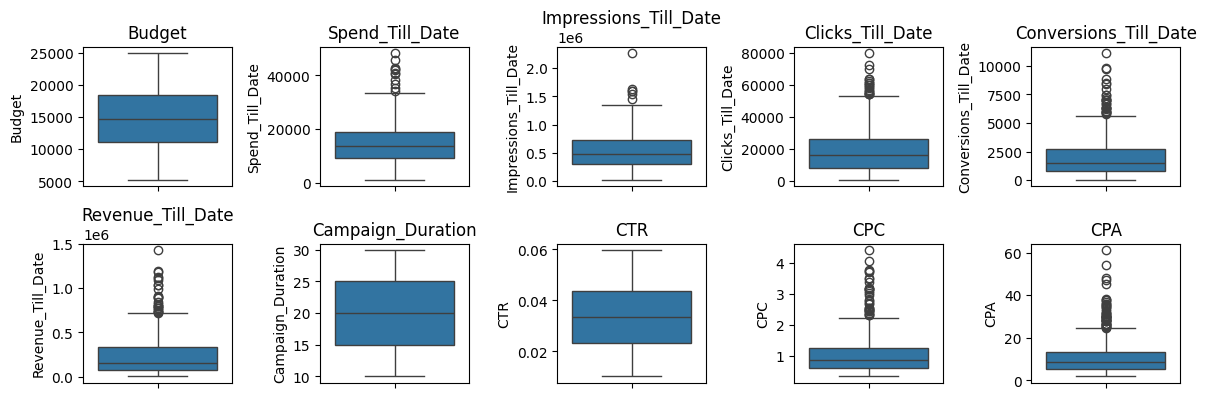

In [267]:
plt.figure(figsize = (12,6))
for i, col in enumerate(df_encoded[numerical_cols]):
    plt.subplot(3,5, i+1)
    sns.boxplot(df_encoded[col])
    plt.title(col)
plt.tight_layout()
plt.show()

####
#### Columns like Budget, Campaign_Duration and CTR can be excluded from transformation process as these cols follow nearly normal distribution.

In [268]:
remove_from_trans = ["Budget", 'CTR', 'Campaign_Duration']
cols_to_transform = [col for col in numerical_cols if col not in remove_from_trans]

for col in cols_to_transform:
    df_encoded[f'{col}_log'] = np.log1p(df_encoded[col])

In [269]:
df_encoded.head(5)

,Status,Budget,Spend_Till_Date,Impressions_Till_Date,Clicks_Till_Date,Conversions_Till_Date,Revenue_Till_Date,Campaign_Duration,CTR,CPC,...,Geo_US,Creative_Type_Image,Creative_Type_Video,Spend_Till_Date_log,Impressions_Till_Date_log,Clicks_Till_Date_log,Conversions_Till_Date_log,Revenue_Till_Date_log,CPC_log,CPA_log
0,0,13085,1904.47,89351,4111,465,39014.89,30,0.046010,0.463262,...,0,0,1,7.552484,11.400339,8.321665,6.144186,10.571724,0.380668,1.628384
1,0,16302,2517.96,73341,2272,211,16694.93,29,0.030979,1.108257,...,0,0,1,7.831601,11.202889,7.728856,5.356586,9.722920,0.745862,2.559818
2,0,8988,1409.12,41938,1671,192,25905.09,29,0.039845,0.843279,...,1,1,0,7.251430,10.643971,7.421776,5.262690,10.162233,0.611546,2.120963
3,0,10171,1846.96,92332,4604,485,61545.89,29,0.049864,0.401164,...,1,1,0,7.521838,11.433157,8.434898,6.186209,11.027555,0.337303,1.570316
4,0,8475,1700.02,41114,891,77,7361.74,30,0.021671,1.907991,...,0,0,1,7.438983,10.624128,6.793466,4.356709,8.904187,1.067462,3.138888


In [270]:
df_transformed = df_encoded.drop(cols_to_transform, axis = 1)

In [271]:
df_transformed

,Status,Budget,Campaign_Duration,CTR,Channel_Google,Channel_Instagram,Channel_LinkedIn,Channel_YouTube,Objective_Leads,Objective_Sales,...,Geo_US,Creative_Type_Image,Creative_Type_Video,Spend_Till_Date_log,Impressions_Till_Date_log,Clicks_Till_Date_log,Conversions_Till_Date_log,Revenue_Till_Date_log,CPC_log,CPA_log
0,0,13085,30,0.046010,0,0,0,0,0,0,...,0,0,1,7.552484,11.400339,8.321665,6.144186,10.571724,0.380668,1.628384
1,0,16302,29,0.030979,0,1,0,0,0,0,...,0,0,1,7.831601,11.202889,7.728856,5.356586,9.722920,0.745862,2.559818
2,0,8988,29,0.039845,0,0,0,0,0,1,...,1,1,0,7.251430,10.643971,7.421776,5.262690,10.162233,0.611546,2.120963
3,0,10171,29,0.049864,0,0,1,0,1,0,...,1,1,0,7.521838,11.433157,8.434898,6.186209,11.027555,0.337303,1.570316
4,0,8475,30,0.021671,1,0,0,0,0,1,...,0,0,1,7.438983,10.624128,6.793466,4.356709,8.904187,1.067462,3.138888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1,22563,12,0.051370,0,0,0,1,0,0,...,1,0,1,9.993410,13.337284,10.368604,8.615408,12.844658,0.523038,1.602918
596,1,19024,13,0.026695,0,0,0,1,0,0,...,0,0,0,9.830889,13.642462,10.019224,7.664347,12.800257,0.603403,2.275387
597,1,13632,12,0.021080,1,0,0,0,0,1,...,0,1,0,9.429930,12.679231,8.819961,7.078342,11.913338,1.043980,2.443239
598,1,8601,10,0.036943,0,1,0,0,1,0,...,0,0,1,8.977297,12.575451,9.277158,7.273093,12.431824,0.554401,1.871822


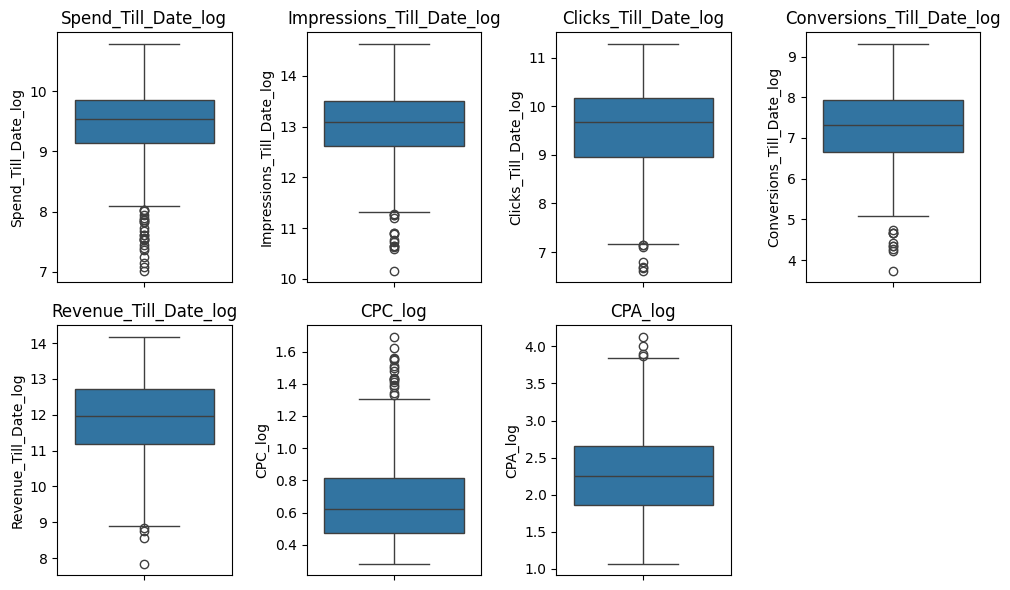

In [276]:
cols = ['Spend_Till_Date_log', 'Impressions_Till_Date_log', 'Clicks_Till_Date_log', 'Conversions_Till_Date_log', 'Revenue_Till_Date_log', 'CPC_log', 'CPA_log']

plt.figure(figsize = (10,6))
for i, col in enumerate(df_transformed[cols]):
    plt.subplot(2,4, i+1)
    sns.boxplot(df_transformed[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Feature Selection
We have used correlation matrix and heatmap to check multicollinearity.

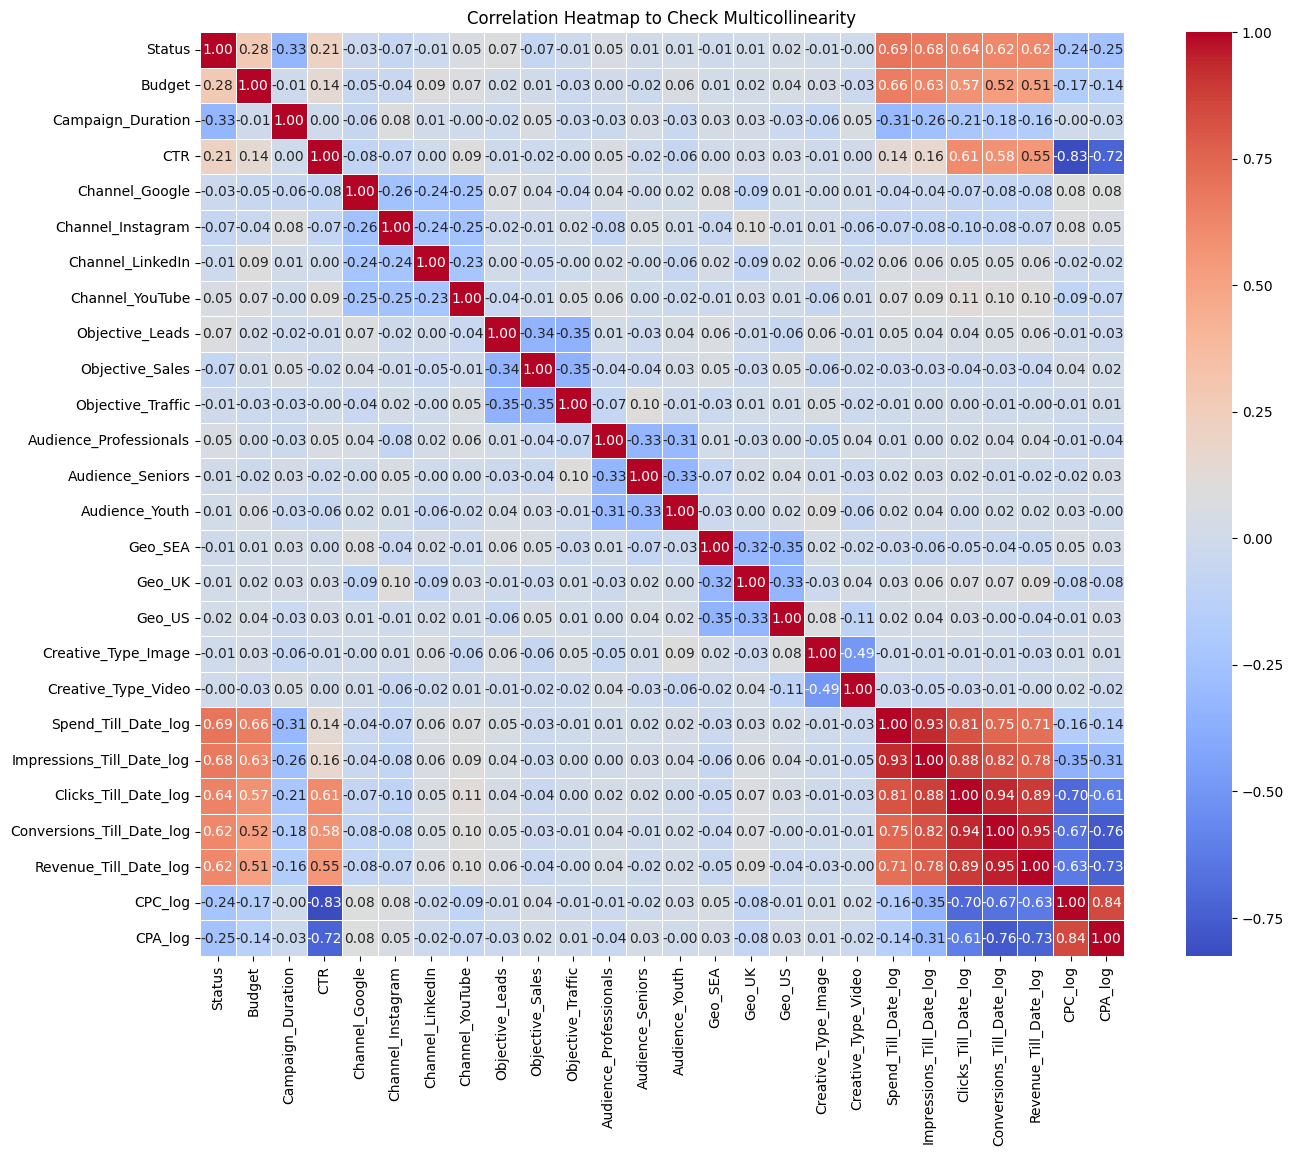

In [185]:
corr_matrix = df_transformed.corr()

# 2. Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap to Check Multicollinearity")
plt.show()

##### Strong positive correlations (red) are seen between:
 * Spend_Till_Date_log, Impressions_Till_Date_log, Clicks_Till_Date_log, Conversions_Till_Date_log, and Revenue_Till_Date_log
 * indicating they move together.
 * Which causes Multicollinearity and as we have created new derived attributes from using these columns then we can remove them.

In [186]:
df_transformed = df_transformed.drop(['Impressions_Till_Date_log', 'Clicks_Till_Date_log', 'Conversions_Till_Date_log'], axis = 1)

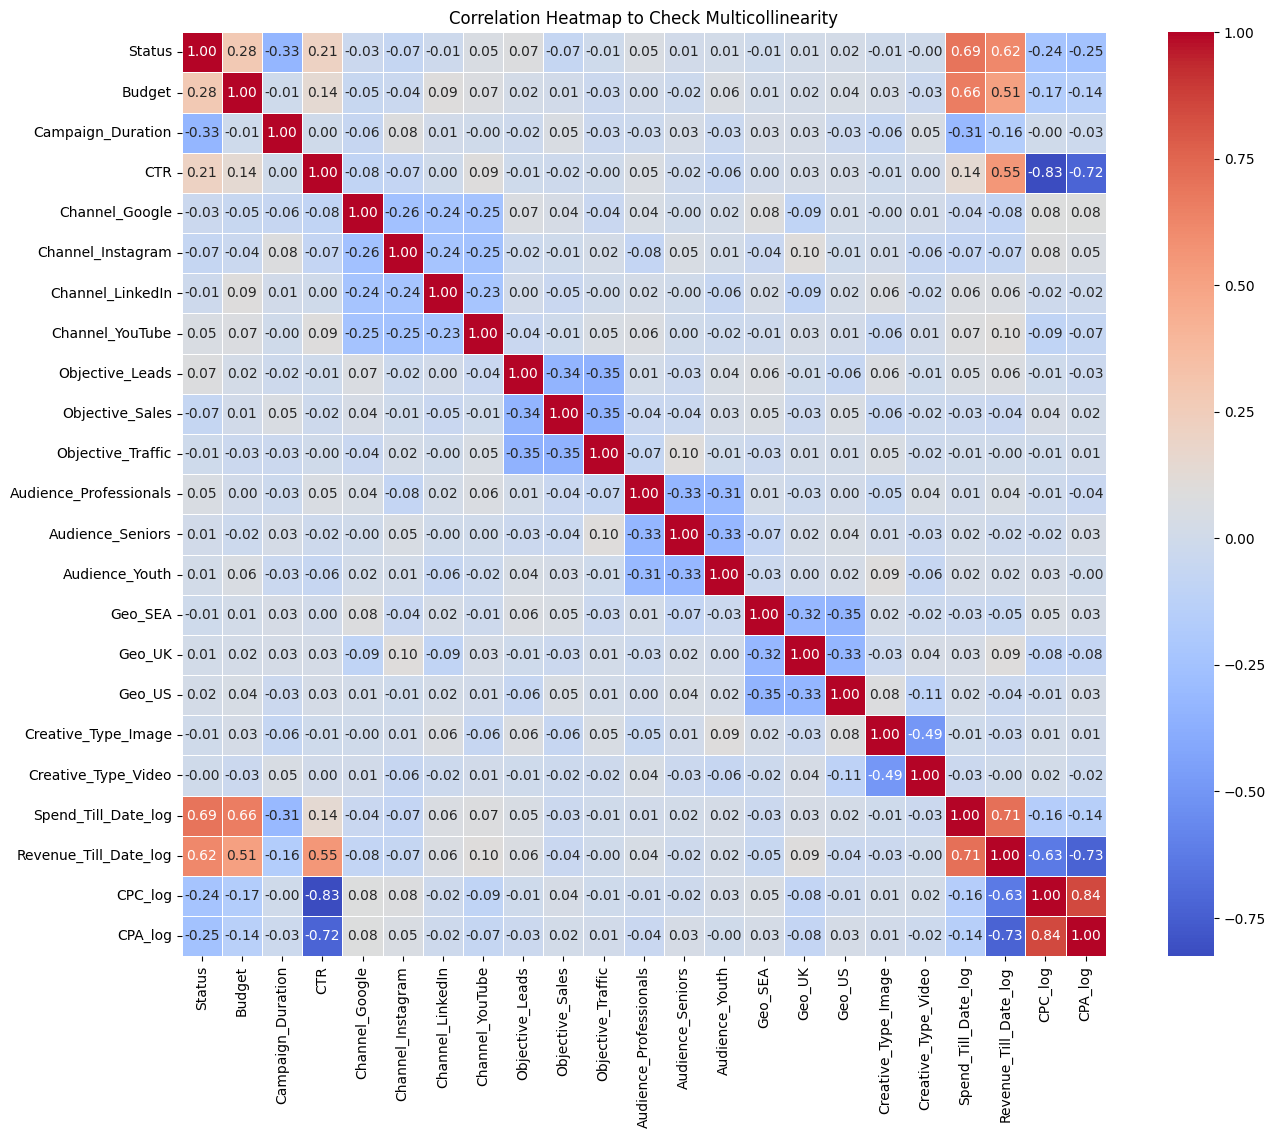

In [187]:
corr_matrix = df_transformed.corr()

# 2. Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap to Check Multicollinearity")
plt.show()

### Splitting our Data
 * After feature transformation the next step is to split our training and testing data.

In [188]:
df_transformed.columns

Index(['Status', 'Budget', 'Campaign_Duration', 'CTR', 'Channel_Google',
       'Channel_Instagram', 'Channel_LinkedIn', 'Channel_YouTube',
       'Objective_Leads', 'Objective_Sales', 'Objective_Traffic',
       'Audience_Professionals', 'Audience_Seniors', 'Audience_Youth',
       'Geo_SEA', 'Geo_UK', 'Geo_US', 'Creative_Type_Image',
       'Creative_Type_Video', 'Spend_Till_Date_log', 'Revenue_Till_Date_log',
       'CPC_log', 'CPA_log'],
      dtype='object')

In [189]:
from sklearn.model_selection import train_test_split

y = df_transformed["Revenue_Till_Date_log"]
x = df_transformed.drop("Revenue_Till_Date_log", axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [190]:
x_train_selected = x_train
x_test_selected = x_test

In [191]:
x_train.columns

Index(['Status', 'Budget', 'Campaign_Duration', 'CTR', 'Channel_Google',
       'Channel_Instagram', 'Channel_LinkedIn', 'Channel_YouTube',
       'Objective_Leads', 'Objective_Sales', 'Objective_Traffic',
       'Audience_Professionals', 'Audience_Seniors', 'Audience_Youth',
       'Geo_SEA', 'Geo_UK', 'Geo_US', 'Creative_Type_Image',
       'Creative_Type_Video', 'Spend_Till_Date_log', 'CPC_log', 'CPA_log'],
      dtype='object')

##
## Baseline Model Comparison

#### Importing all necessary libraries for Modelling

In [192]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import time

####
 * We will define a function to evaluate desired evaluation metrics for each model.
 * The considered Evaluation Metrics are : RMSE and R Square

In [193]:
def evaluate_model(model, x, y, cv=5):
    scoring = {
        'rmse': 'neg_root_mean_squared_error',
        'r2': 'r2'
    }

    scores = cross_validate(model, x, y, scoring=scoring, cv=cv)

    mean_rmse = -np.mean(scores['test_rmse'])  # Negated because sklearn uses negative RMSE
    std_rmse = np.std(scores['test_rmse'])

    mean_r2 = np.mean(scores['test_r2'])
    std_r2 = np.std(scores['test_r2'])

    return mean_rmse, std_rmse, mean_r2, std_r2

####
#### To finalize the best fit model we will evaluate all these models based on the defined metrics

In [204]:
models = {
    #'LinearRegression': LinearRegression(),
    #'KNN': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    #'SVR': SVR(),
    'XGBoost': XGBRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

results = {
    'Model' : [],
    'RMSE Mean' : [],
    'RMSE Std' : [],
    'R2 Mean' : [],
    'R2 Std' : [],
    'Building Time (s)' : []
}

for name, model in models.items():
    start_time = time.time()
    
    mean_rmse, std_rmse, mean_r2, std_r2 = evaluate_model(model, x_train_selected, y_train)
    
    end_time = time.time()
    building_time = end_time - start_time

    
    results['Model'].append(name)
    results['RMSE Mean'].append(mean_rmse)
    results['RMSE Std'].append(std_rmse)
    results['R2 Mean'].append(mean_r2)
    results['R2 Std'].append(std_r2)
    results['Building Time (s)'].append(building_time)

Evaluations = pd.DataFrame(results)
Evaluations.sort_values(by = ['R2 Mean', 'RMSE Mean'], ascending = False)

,Model,RMSE Mean,RMSE Std,R2 Mean,R2 Std,Building Time (s)
3,GradientBoosting,0.373262,0.039033,0.872682,0.022555,2.251754
1,RandomForest,0.383384,0.038879,0.866859,0.016233,4.569580
2,XGBoost,0.415618,0.035839,0.843166,0.017946,1.245130
0,DecisionTree,0.514774,0.031460,0.757878,0.031116,0.157874


######
**Conclusion** -
   * As we can notice here **GradientBoosting** is the best candidate here with highest R2 score and lowest RMSE.
   * Followed by **RandomForest** and **XGBoost**.
   * We will select these 3 algorithms for further modelling, all the other models are with comparatively low R2 and high error.

#
## Model Optimization - Hyperparameter Tuning

#### For Random Forest Regression

In [196]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator= RandomForestRegressor(),
    param_distributions=param_dist,
    n_iter=500,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=101,
    n_jobs=-1
)

random_search.fit(x_train_selected, y_train)
best_rfr = random_search.best_estimator_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


####
#### XGBoost Regression

In [197]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2.0]
}

random_search = RandomizedSearchCV(
    estimator= XGBRegressor(),
    param_distributions=param_dist,
    n_iter=500,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=101,
    n_jobs=-1
)

random_search.fit(x_train_selected, y_train)
best_xgbr = random_search.best_estimator_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


####
#### For GradientBoost Regression

In [198]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator= GradientBoostingRegressor(),
    param_distributions=param_dist,
    n_iter=500,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=101,
    n_jobs=-1
)

random_search.fit(x_train_selected, y_train)
best_gbr = random_search.best_estimator_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


##
## Model Selection

We processed hyperparameter tuning with selected regression algorithms and all optimized models are selected in **best_[model]** variable.
Now we will train our models on training data and evaluate them based on evaluation metrics. The model with high accuracy and low error will be our final model.

####
#### 1. Random Forest Regression Model

In [200]:
best_rfr.fit(x_train_selected, y_train)

rfr_y_pred = best_rfr.predict(x_test_selected)

r2_rfr = r2_score(y_test, rfr_y_pred)
mae_rfr = mean_absolute_error(y_test, rfr_y_pred)
rmse_rfr = np.sqrt(mean_squared_error(y_test, rfr_y_pred))

####
#### 2. XGBoost Regression Model

In [201]:
best_xgbr.fit(x_train_selected, y_train)

xgbr_y_pred = best_xgbr.predict(x_test_selected)

r2_xgbr = r2_score(y_test, xgbr_y_pred)
mae_xgbr = mean_absolute_error(y_test, xgbr_y_pred)
rmse_xgbr = np.sqrt(mean_squared_error(y_test, xgbr_y_pred))

####
#### 3. Gradient Boosting Regression Model

In [202]:
best_gbr.fit(x_train_selected, y_train)

gbr_y_pred = best_gbr.predict(x_test_selected)

r2_gbr = r2_score(y_test, gbr_y_pred)
mae_gbr = mean_absolute_error(y_test, gbr_y_pred)
rmse_gbr = np.sqrt(mean_squared_error(y_test, gbr_y_pred))

####
#### Evaluating the best fit model for our prediction task based on following metrics

In [207]:
Evaluation_BestM = pd.DataFrame({"Model Name" : ["Random Forest", "XGBoost", "Gradient Boosting"],
                           "MAE" : [mae_rfr, mae_xgbr, mae_gbr],
                           "RMSE" : [rmse_rfr, rmse_xgbr, rmse_gbr],
                           "R_Square" : [r2_rfr, r2_xgbr, r2_gbr]})
Evaluation_BestM
Evaluation_BestM.sort_values(by = ['R_Square', 'RMSE'], ascending = False)

,Model Name,MAE,RMSE,R_Square
1,XGBoost,0.301604,0.375091,0.882934
2,Gradient Boosting,0.313118,0.385615,0.876273
0,Random Forest,0.358081,0.458457,0.825114


##
## Conclusion :
From the above evaluation scores, the best model is **XGBOOST** !
 * It gives lowest MAE (0.30) and lowest RMSE: (0.37) which is comparatively better than others.
 * This model provides highest co-efficient of determination (0.88 %)
 * XGBoost provided best balance of accuracy and generalization and, errors are small and consistent.

##
## Feature Importance From XGBoost Model:
We can extract and visualize feature importance from our XGBoost model.

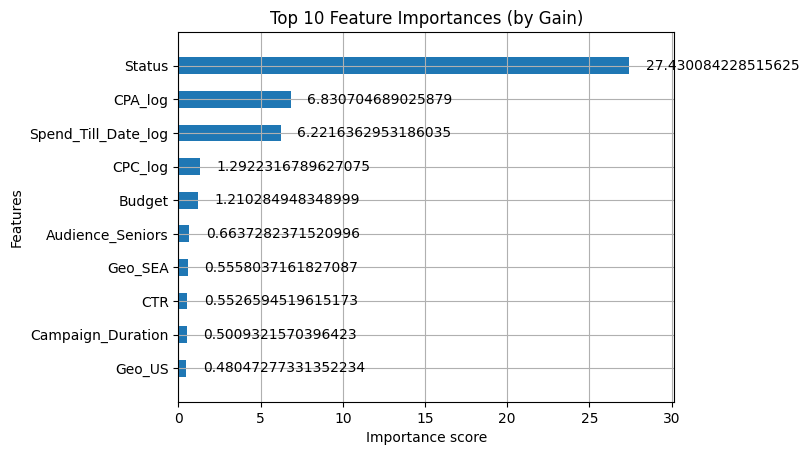

In [208]:
import xgboost as xgb

xgb.plot_importance(best_xgbr, importance_type='gain', max_num_features=10, height=0.5)
plt.title('Top 10 Feature Importances (by Gain)')
plt.show()

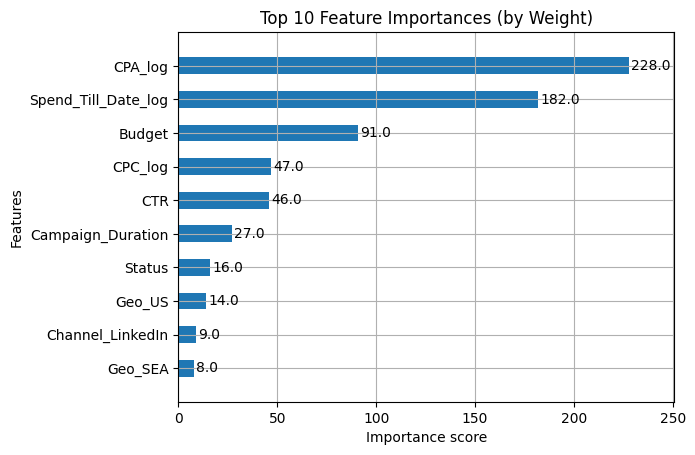

In [209]:
xgb.plot_importance(best_xgbr, importance_type='weight', max_num_features=10, height=0.5)
plt.title('Top 10 Feature Importances (by Weight)')
plt.show()

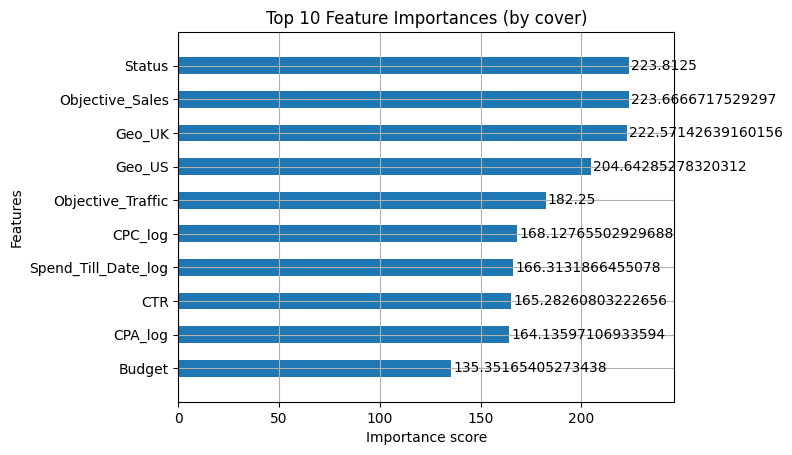

In [210]:
xgb.plot_importance(best_xgbr, importance_type='cover', max_num_features=10, height=0.5)
plt.title('Top 10 Feature Importances (by cover)')
plt.show()

# prediction on user inputs

In [211]:
model_columns = x_train_selected.columns.tolist()
model_columns

['Status',
 'Budget',
 'Campaign_Duration',
 'CTR',
 'Channel_Google',
 'Channel_Instagram',
 'Channel_LinkedIn',
 'Channel_YouTube',
 'Objective_Leads',
 'Objective_Sales',
 'Objective_Traffic',
 'Audience_Professionals',
 'Audience_Seniors',
 'Audience_Youth',
 'Geo_SEA',
 'Geo_UK',
 'Geo_US',
 'Creative_Type_Image',
 'Creative_Type_Video',
 'Spend_Till_Date_log',
 'CPC_log',
 'CPA_log']

In [212]:
import joblib

# Save after training
joblib.dump(best_xgbr, "model.pkl")
#joblib.dump(scaler, "scaler.pkl")
joblib.dump(model_columns, "model_columns.pkl")

['model_columns.pkl']

In [213]:
# Load before prediction
model = joblib.load("model.pkl")
#scaler = joblib.load("scaler.pkl")
model_columns = joblib.load("model_columns.pkl")

In [218]:
import pandas as pd
import numpy as np

def predict_campaign_revenue(user_input: dict, model, scaler, model_columns):
    one_hot_cols = ["Channel", "Objective", "Audience", "Geo", "Creative_Type"]
    binary_cols = ["Status"]

    # Step 1: Create dataframe
    input_df = pd.DataFrame([user_input])

    # Step 2: Binary mapping
    for col in binary_cols:
        if col in input_df.columns:
            input_df[col] = input_df[col].map({"Completed": 1, "Active": 0})
        else:
            input_df[col] = 0

    # Step 3: Derived features
    impressions = input_df.get("Impressions_Till_Date", 0).values[0]
    clicks = input_df.get("Clicks_Till_Date", 0).values[0]
    conversions = input_df.get("Conversions_Till_Date", 0).values[0]
    spend = input_df.get("Spend_Till_Date", 0).values[0]

    input_df["CTR"] = clicks / impressions if impressions > 0 else 0
    input_df["CPC"] = spend / clicks if clicks > 0 else 0
    input_df["CPA"] = spend / conversions if conversions > 0 else 0

    # Step 4: Log transforms
    input_df["Spend_Till_Date_log"] = np.log1p(spend)
    input_df["CPC_log"] = np.log1p(input_df["CPC"])
    input_df["CPA_log"] = np.log1p(input_df["CPA"])

    # Step 5: Drop raw versions not used in training
    drop_cols = ["Spend_Till_Date", "CPC", "CPA"]
    input_df = input_df.drop(columns=[c for c in drop_cols if c in input_df.columns])

    # Step 6: One-hot encode categoricals
    input_encoded = pd.get_dummies(input_df, columns=one_hot_cols, drop_first=True, dtype='int')

    # Step 7: Align with model columns
    input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)

    # Step 8: Predict and inverse log
    prediction = model.predict(input_encoded)
    revenue = np.expm1(prediction[0])

    return revenue

In [235]:
user_input = {
    "Channel": "Instagram",
    "Objective": "Sales",
    "Audience": "Adults",
    "Geo": "US",
    "Creative_Type": "Carousel",
    "Status": "Active",
    "Budget": 13849,
    "Spend_Till_Date": 5400,
    "Impressions_Till_Date": 108755,
    "Clicks_Till_Date": 2538,
    "Conversions_Till_Date": 227,
    "Campaign_Duration": 25
    #"Duration_Till_Date": 12
}

revenue = predict_campaign_revenue(user_input, model, scaler, model_columns)
print(f"Predicted Revenue: {revenue:.2f}")

Predicted Revenue: 28296.11


In [239]:
user_input = {
    "Channel": "LinkedIn",
    "Objective": "Awareness",
    "Audience": "Adults",
    "Geo": "India",
    "Creative_Type": "Video",
    "Status": "Active",
    "Budget": 7868,
    "Spend_Till_Date": 0,
    "Impressions_Till_Date": 0,
    "Clicks_Till_Date": 0,
    "Conversions_Till_Date": 0,
    "Campaign_Duration": 30,
    #"Duration_Till_Date": 0
}

revenue = predict_campaign_revenue(user_input, model, scaler, model_columns)
print(f"Predicted Revenue: {revenue:.2f}")

Predicted Revenue: 77890.05


# Final Loading of Joblib File

In [226]:
import joblib

# Load your existing objects 
# Bundle into one dictionary

pipeline_artifacts = {
    "model": best_xgbr,
    "scaler": scaler,
    "model_columns": model_columns
}
 
# Save as a single joblib file

joblib.dump(pipeline_artifacts, "roi_pipeline_new.joblib")
print("✅ Combined into roi_pipeline.joblib")

✅ Combined into roi_pipeline.joblib
